## INTRO & SETTINGS

The goal of this tutorial is to show the capabilities of `lf2i` and `Waldo` with a simple example: inferring the mean $\theta \in \mathbb{R}^{2}$ of a Gaussian model with fixed covariance, and a Gaussian prior distribution

$$\boldsymbol{\theta} \sim \mathcal{N}(\mathbb{0}, 0.1 \odot \mathbb{I}), \\ \text{ } \mathbf{X}|\boldsymbol{\theta} \sim \mathcal{N}(\boldsymbol{\theta}, 0.01 \odot \mathbb{I})$$

In addition, we assume that we only observe one sample for each true $\boldsymbol{\theta}$, i.e., $n=1$. \
For this tutorial, we leverage a posterior estimator (`NPE`) as the main underlying inferential model.

In [2]:
# SETTINGS

LIKELIHOOD_COV = 0.01
PRIOR_LOC = 0
PRIOR_COV = 0.1

PARAM_DIM = 2
DATA_DIM = 2
DATA_SAMPLE_SIZE = 1  # assume we get to see only one observed sample for each “true” parameter
PARAM_SPACE_BOUNDS = {'low': -1.5, 'high': 1.5}  # a grid of points over [low, high]^(param_dim) is used to construct confidence sets

CONFIDENCE_LEVEL = 0.90

## SIMULATE

Let's start from the simulator, which is used internally to generate the data needed to 
1. estimate the test statistics;
2. estimate the critical values; and 
3. diagnose the constructed confidence regions 

In [3]:
from lf2i.simulator.gaussian import GaussianMean

In [4]:
simulator = GaussianMean(
    likelihood_cov=LIKELIHOOD_COV,
    prior='gaussian',
    parameter_space_bounds=PARAM_SPACE_BOUNDS,
    param_grid_size=10_000,
    param_dim=PARAM_DIM, 
    data_dim=DATA_DIM,
    data_sample_size=DATA_SAMPLE_SIZE,
    prior_kwargs={'loc': PRIOR_LOC, 'cov': PRIOR_COV}
)

#### Observations

For simplicity, let's use the simulator to generate two “observed” samples from the true likelihood: one consistent with the prior ($\boldsymbol{\theta}^{\star} = [0, 0]$) and one not ($\boldsymbol{\theta}^{\star} = [-1.45, 1.45]$)

In [5]:
import torch

true_param_consistent, true_param_notconsistent = torch.Tensor([0, 0]), torch.Tensor([-1.45, 1.45])
observed_x_consistent = simulator.likelihood(true_param_consistent).sample(sample_shape=(DATA_SAMPLE_SIZE, ))
observed_x_notconsistent = simulator.likelihood(true_param_notconsistent).sample(sample_shape=(DATA_SAMPLE_SIZE, ))

## CONFIDENCE SET by leveraging a POSTERIOR ESTIMATOR

Assume we want to do inference on the Gaussian mean by estimating its posterior distribution. `Waldo` allows to leverage a neural posterior estimator like `NPE` to obtain a confidence region for the parameter of interest that is guaranteed to have the desired level of coverage regardless of 
1. the consistency of the prior distribution with the data;
2. the true value of the parameter;
3. the size of the observed sample

The posterior estimator can be already trained or not. The example below assumes the estimator has *not* been trained yet

In [6]:
from lf2i.inference.lf2i import WALDO
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_region

In [7]:
waldo = WALDO(
    simulator=simulator,
    estimator='snpe',
    method='posterior',
    confidence_level=CONFIDENCE_LEVEL,
    num_posterior_samples=20_000  # used to approximate conditional mean and variance of the Waldo test statistic
)

In [8]:
confidence_region = waldo.infer(
    x=torch.vstack((observed_x_consistent, observed_x_notconsistent)), 
    b=20_000, b_prime=10_000,
    quantile_regressor='gb',
    quantile_regressor_kwargs={'n_estimators': 1000, 'max_depth': 5}
)

 Neural network successfully converged after 61 epochs.

Approximating conditional mean and covariance: 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]


### Observation consistent with the prior

Waldo Confidence Region

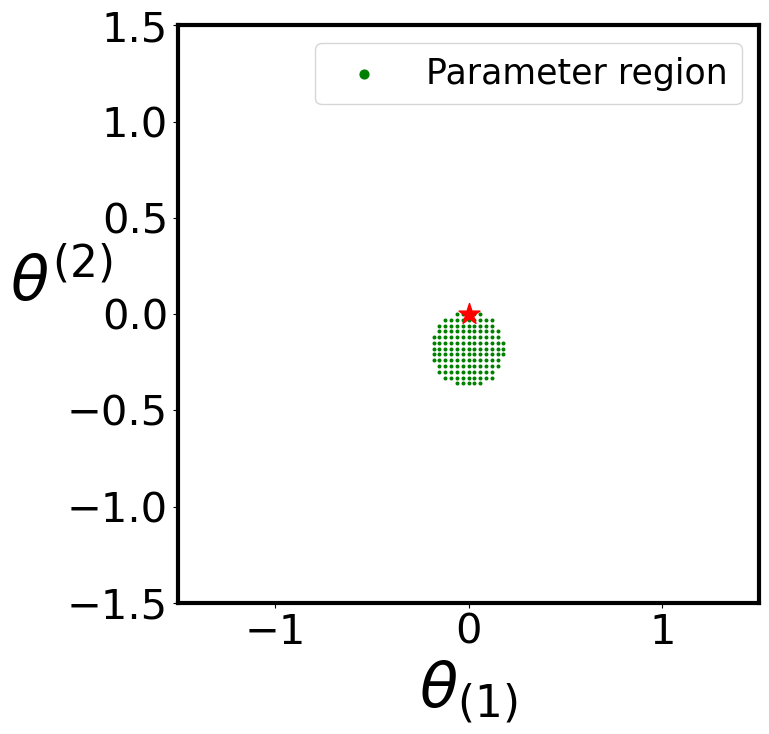

In [9]:
# The red star in the plot is the true parameter

plot_parameter_region(
    parameter_region=confidence_region[0],
    param_dim=PARAM_DIM,
    true_parameter=true_param_consistent,
    parameter_space_bounds=simulator.parameter_space_bounds,
    figsize=(7.5, 7.5)
)

Posterior Credible Region

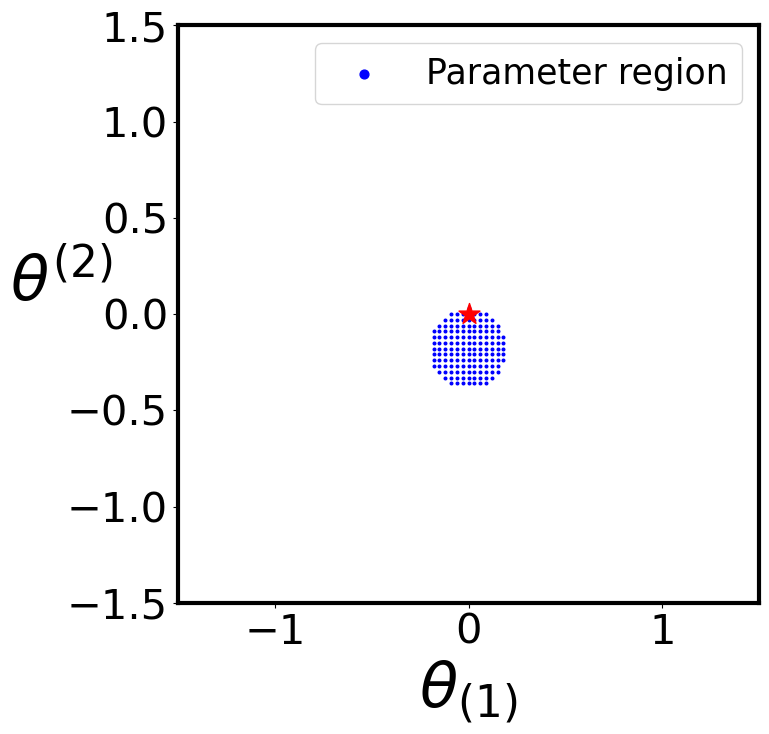

In [10]:
plot_parameter_region(
    parameter_region=hpd_region(
        posterior=waldo.test_statistic.estimator,
        param_grid=simulator.param_grid,
        x=observed_x_consistent,
        confidence_level=CONFIDENCE_LEVEL
    )[1],
    param_dim=PARAM_DIM,
    true_parameter=true_param_consistent,
    parameter_space_bounds=simulator.parameter_space_bounds,
    figsize=(7.5, 7.5),
    color='blue'
)

### Observation *not* consistent with the prior

Waldo Confidence Region

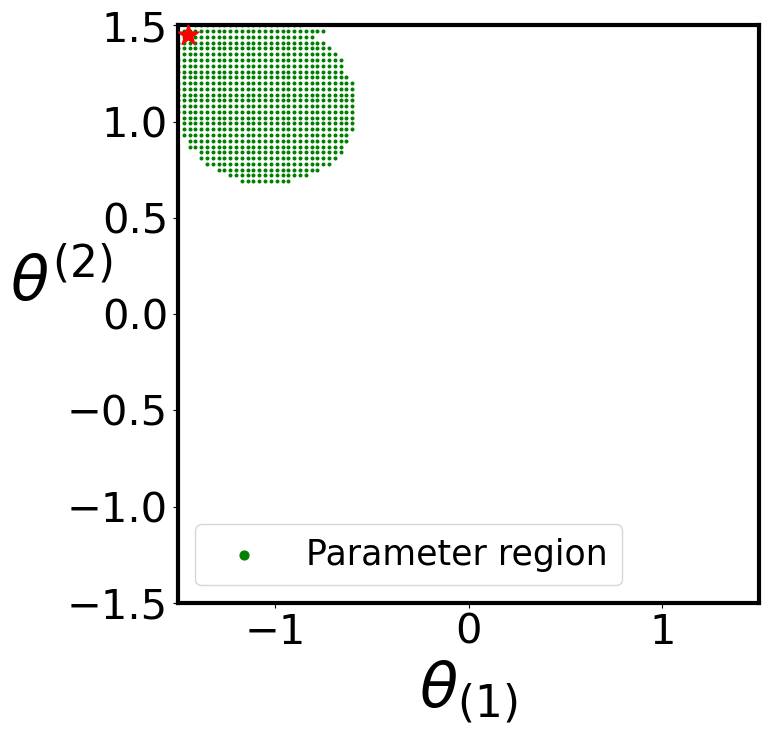

In [11]:
plot_parameter_region(
    parameter_region=confidence_region[1],
    param_dim=PARAM_DIM,
    true_parameter=true_param_notconsistent,
    parameter_space_bounds=simulator.parameter_space_bounds,
    figsize=(7.5, 7.5)
)

Posterior Credible Region

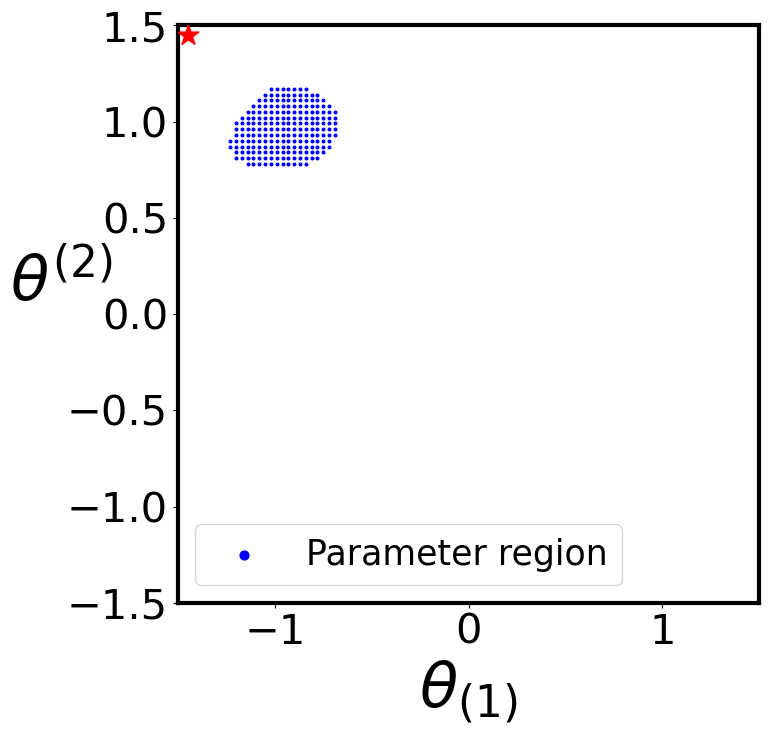

In [12]:
plot_parameter_region(
    parameter_region=hpd_region(
        posterior=waldo.test_statistic.estimator,
        param_grid=simulator.param_grid,
        x=observed_x_notconsistent,
        confidence_level=CONFIDENCE_LEVEL
    )[1],
    param_dim=PARAM_DIM,
    true_parameter=true_param_notconsistent,
    parameter_space_bounds=simulator.parameter_space_bounds,
    figsize=(7.5, 7.5),
    color='blue'
)

## DIAGNOSTICS

In [13]:
from lf2i.plot.coverage_diagnostics import coverage_regions_plot

#### Posterior Credible Regions

In [16]:
parameters, mean_proba, upper_proba, lower_proba = waldo.diagnose(
    b_doubleprime=10_000,
    region_type='posterior',
)

Computing indicators for credible regions: 100%|██████████| 10000/10000 [15:09<00:00, 10.99it/s]


Coverage of posterior credible regions can be very erratic: they tend to overcover close to the “bulk” of the prior and severely undercover far from it. The correct level here is 90%

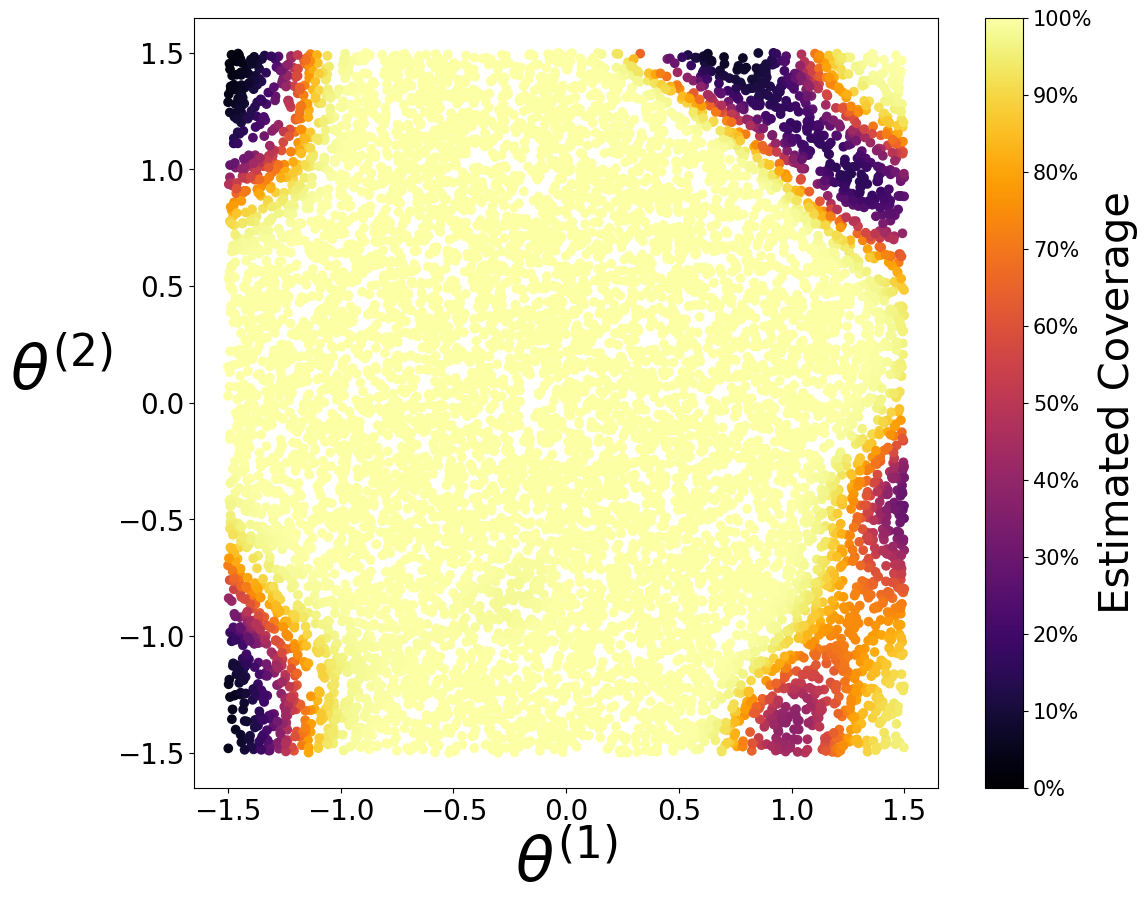

In [17]:
# only plotting mean coverage probability in 2 dimensions
coverage_regions_plot(
    parameters=parameters,
    mean_proba=mean_proba, 
    upper_proba=None,
    lower_proba=None,
    confidence_level=CONFIDENCE_LEVEL,
    param_dim=PARAM_DIM,
    figsize=(12, 10)
)

#### Waldo Confidence Regions

In [14]:
parameters, mean_proba, upper_proba, lower_proba = waldo.diagnose(
    b_doubleprime=10_000,
    region_type='lf2i'
)

Approximating conditional mean and covariance: 100%|██████████| 10000/10000 [14:30<00:00, 11.48it/s]
R[write to console]: Loading required package: nlme

R[write to console]: This is mgcv 1.8-38. For overview type 'help("mgcv-package")'.



Coverage of Waldo is approximately 90% everywhere, as desired

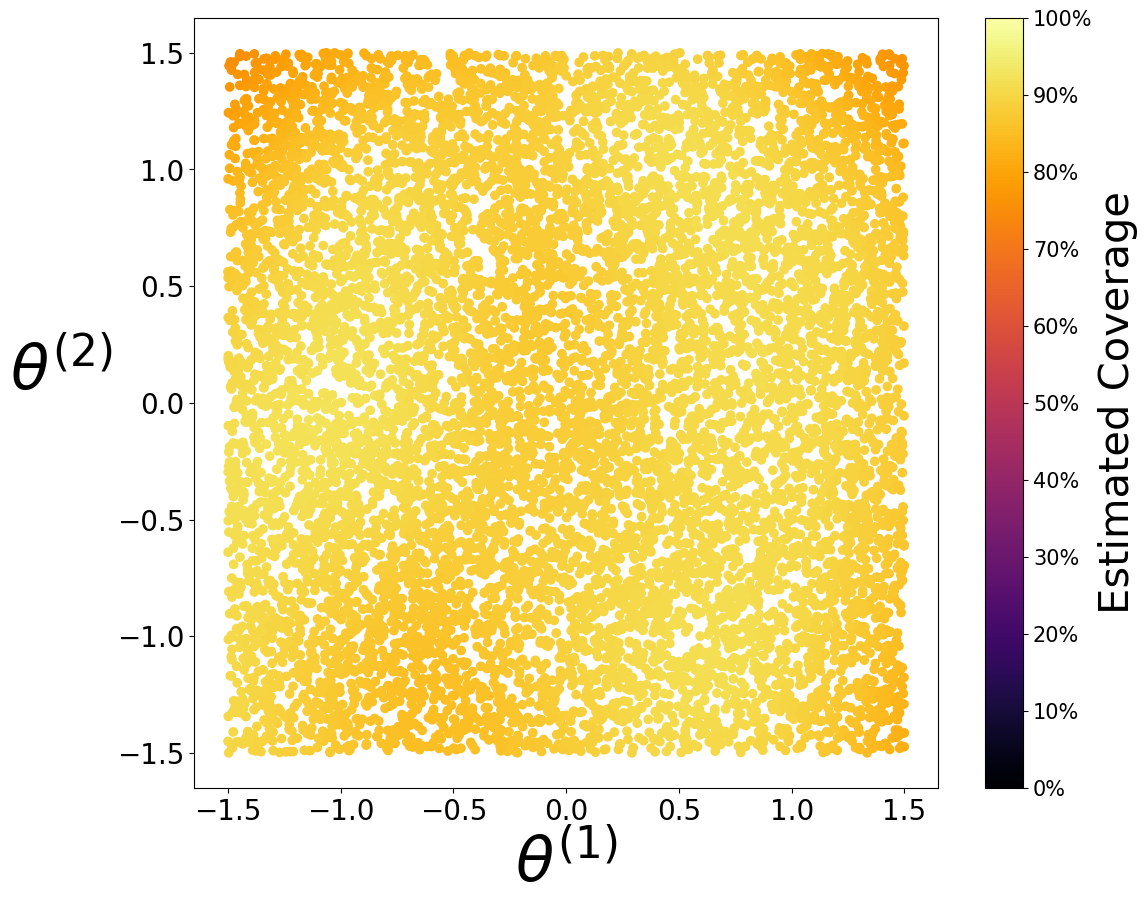

In [15]:
# only plotting mean coverage probability in 2 dimensions
coverage_regions_plot(
    parameters=parameters,
    mean_proba=mean_proba, 
    upper_proba=None,
    lower_proba=None,
    confidence_level=CONFIDENCE_LEVEL,
    param_dim=PARAM_DIM,
    figsize=(12, 10)
)